In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
import os, glob
import gc

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Load data
df = pd.read_csv('log_95k.csv',sep=',',quotechar='/', index_col='id')
df['article_url'] = df['article_url'].apply(lambda _: _[len('/wiki/'):])
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94992 entries, 0 to 94991
Data columns (total 9 columns):
categories     93758 non-null object
article_url    94992 non-null object
name           92460 non-null object
author         94992 non-null object
translator     16316 non-null object
author_url     94992 non-null object
verified       94992 non-null bool
content_len    94992 non-null int64
oldspell       94992 non-null bool
dtypes: bool(2), int64(1), object(6)
memory usage: 6.0+ MB


## Анализ

Получаем все возможные категории( с повторением)

In [3]:
df['cats'] = df['categories'].str.split('##')
total_categories = []
df['cats'].apply(lambda _: total_categories.extend(_ if _ is not nan else []));
categories = pd.Series(total_categories)

Наиболее популярные категории  и авторы

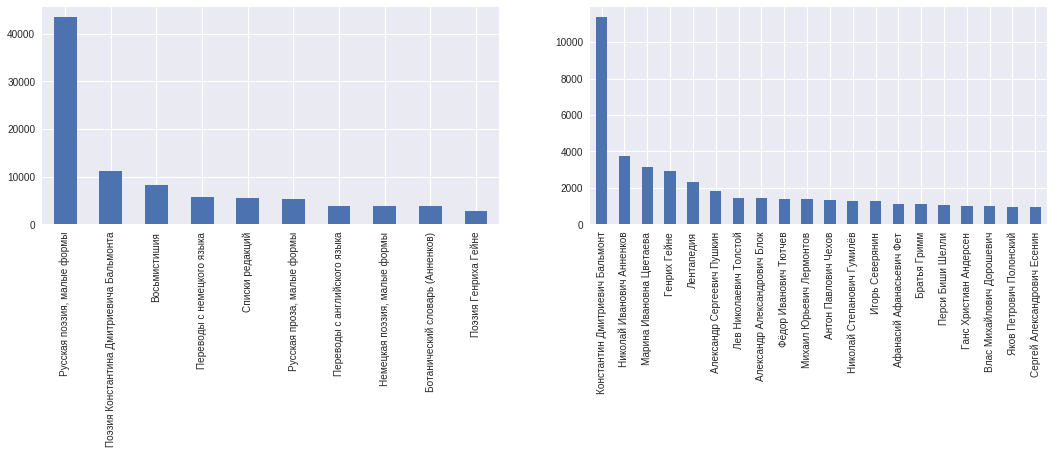

In [4]:
plt.subplots(1,2,figsize=(18,4))
plt.subplot(1,2,1)
categories.value_counts()[:10].plot.bar();

plt.subplot(1,2,2)
df['author'].value_counts()[:20].plot.bar();

# Чистка

Удаляем Лентапедию, которая непонятно что тут делает

In [5]:
tmp_mask = (df['author']=="Лентапедия") | (df['article_url'].apply(lambda _: 'Лентапедия' in _))
drop_mask = tmp_mask
(tmp_mask).value_counts()

False    92684
True      2308
dtype: int64

Удаляем пустые статьи

In [6]:
drop_mask |= (df['content_len']==0)
(df['content_len']==0).value_counts()

False    94723
True       269
Name: content_len, dtype: int64

По хорошему стоит выкинуть произвдения с дореформенной орфографией, а также все непроверенные произведения. Можно прикинуть сколько останется статей в выборке из 95к...

In [7]:
(((df['oldspell']==False) & (df['verified']==True))==True).sum()

62595

Альтернативой( для статей с дореформенной орфаграфией) является автоматической конвертор.

- Качественно, но долго + надо делать API. [клац](http://slavenica.com/)
- Быстро, но не очень качественно + API уже готов. [клац](https://tools.wmflabs.org/ruwikisource/text2do/)

**Update**:

почти все произведения в дореформенной орфографии конвертированы на современный язык. Если это так, значит их  можно безболезненно  выкинуть.

Для проверки стоит заметить, что названия отличаются лишь частью до последнего слэша. Выкинем всё после последнего слэша и сделаем сортировку по названию

**Update**:

такой подход не работает, ибо в url статьи указания на дореформенную орфогрфию:
    1. в разном виде
    2. в разном месте
    
Пока забьём на это дело и просто выкинем такие статьи.

Удаляем произведения с дореформенной орфографией

In [8]:
drop_mask |= df['oldspell']
df['oldspell'].value_counts()

False    76680
True     18312
Name: oldspell, dtype: int64

Удаляем непроверенные произведения

In [9]:
# под вопросом, пока оставим всё
# drop_mask |= df['verified']
# df['verified'].value_counts()

Смотрим, что осталось

In [10]:
df = df[~drop_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74213 entries, 0 to 94991
Data columns (total 10 columns):
categories     73455 non-null object
article_url    74213 non-null object
name           74022 non-null object
author         74213 non-null object
translator     12009 non-null object
author_url     74213 non-null object
verified       74213 non-null bool
content_len    74213 non-null int64
oldspell       74213 non-null bool
cats           73455 non-null object
dtypes: bool(2), int64(1), object(7)
memory usage: 5.2+ MB


## Фильтруем произведения

In [11]:
author_counts = df['author'].value_counts().reset_index()
author_counts.columns = ['author','count']

Выберём произведения только тех авторов, чьё общее число произведений больше некоторого порога.

Обобщим, и посмотрим как сильно проседает число выборки с ростом порога по числу статей

In [12]:
%%time
count_thresholds = list(range(10,1001, 50))
sizes = []
authors_counts = []
categories_counts = []
chars_count = []
for threshold in count_thresholds:
    sel_authors = set(author_counts[author_counts['count']>threshold]['author'].values)
    authors_counts.append(len(sel_authors))
    mask = df['author'].apply(lambda _: _ in sel_authors)
    sizes.append(mask.sum())

    total_categories = []
    df[mask]['cats'].apply(lambda _: total_categories.extend(_ if _ is not nan else []));
    categories_counts.append(pd.Series(total_categories).unique().shape[0])
    
    chars_count.append(df[mask]['content_len'].sum())

CPU times: user 2.22 s, sys: 12 ms, total: 2.23 s
Wall time: 2.23 s


по ходу дела выделим признак число статей в выборке для каждого автора

In [32]:
df['total_count'] = df['author'].replace(author_counts.set_index('author').to_dict()['count'])

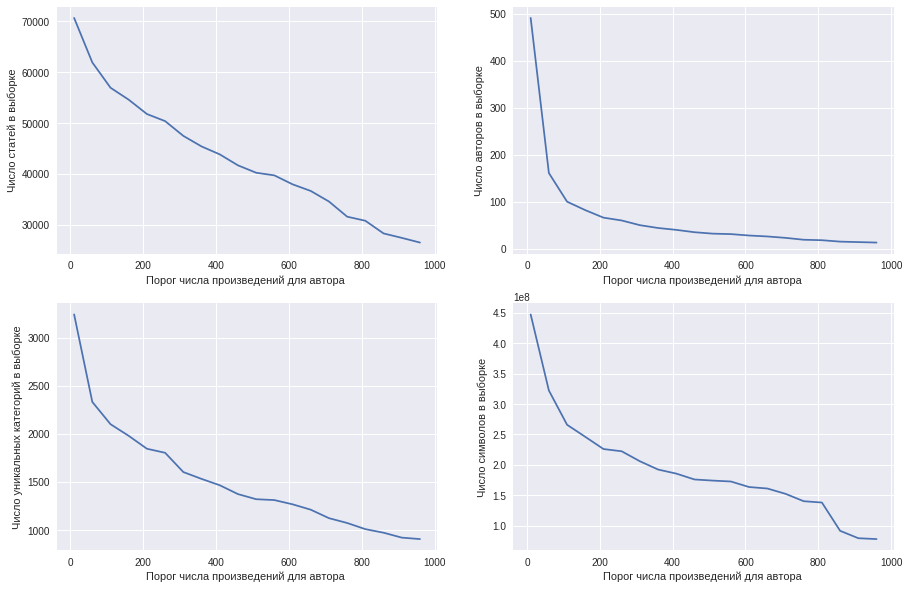

In [13]:
plt.subplots(2,2,figsize=(15,10))

plt.subplot(2,2,1)
plt.plot(count_thresholds, sizes);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число статей в выборке')
plt.subplot(2,2,2)
plt.plot(count_thresholds, authors_counts);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число авторов в выборке');

plt.subplot(2,2,3)
plt.plot(count_thresholds, categories_counts);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число уникальных категорий в выборке');

plt.subplot(2,2,4)
plt.plot(count_thresholds, chars_count);
plt.xlabel('Порог числа произведений для автора ');
plt.ylabel('Число символов в выборке');

### сохраним дополненный dataframe

In [35]:
df.to_csv('prepared_info.csv',sep=',',quotechar='/')

## Анализ  статей из отдельных категорий

In [232]:
def analyze_category_mask(category_name, count_threshold, qrange):
    mask = df['cats'].apply(lambda _: (category_name in _) if _ not in [None,nan] else False)
    print('Общее число статей в категории:', mask.sum())
    counts = df[mask]['author'].value_counts()
    
    print('Число уникальных авторов в разделе {}: {}'.format(category_name,counts.shape[0]))
    print('Число уникальных авторов в разделе {} с более чем {} статьями: {}'.format(category_name,
                                                       count_threshold, 
                                                       counts[counts.values>count_threshold].shape[0]))
    
    print('Общее число их статей в разделе {}: {}'.format(category_name,
                        counts[counts.values>count_threshold].values.sum()))

    q1,q2 = qrange
    q1v = np.percentile(counts[counts.values>count_threshold].values, q1)
    q2v = np.percentile(counts[counts.values>count_threshold].values, q2)
    print(('Можно утверждать, что число статей для {:.3f}  авторов из выборки  '
            'лежит в интервале: ({},{})').format((q2-q1)/100, q1v,q2v))
    
    return counts, mask

In [241]:
import json 
# from lxml import html

def get_content(id_, datapath='/media/grigory/Data/WIKIDATA'):
    with open(os.path.join(datapath, str(id_)+'.json'),'r') as f:
        file_content = json.load(f)
#     html_dom = html.fromstring(file_content['body'])
#     try:
# #         poetry_dom = html_dom.xpath(r'//div[@class="poem"]')
# #         drama_dom = html_dom.xpath(r'//div[@class="drama text"]')
# #         text = html_dom.xpath(r'//div[@class="indent"]')
#         raw_text = html_dom.xpath(r'//div[@class="mw-parser-output"]//p')
#         return '\n\n'.join(p.text_content() for p \
#                           in raw_text if p.getparent().get('class') is not None)
#     except IndexError:
#         pass
    return file_content['content']

## *"Русская поэзия, малые формы"*

In [234]:
poetry_counts, mask = analyze_category_mask('Русская поэзия, малые формы', 100, (30,90))

Общее число статей в категории: 38646
Число уникальных авторов в разделе Русская поэзия, малые формы: 421
Число уникальных авторов в разделе Русская поэзия, малые формы с более чем 100 статьями: 53
Общее число их статей в разделе Русская поэзия, малые формы: 34538
Можно утверждать, что число статей для 0.600  авторов из выборки  лежит в интервале: (246.2,1010.2)


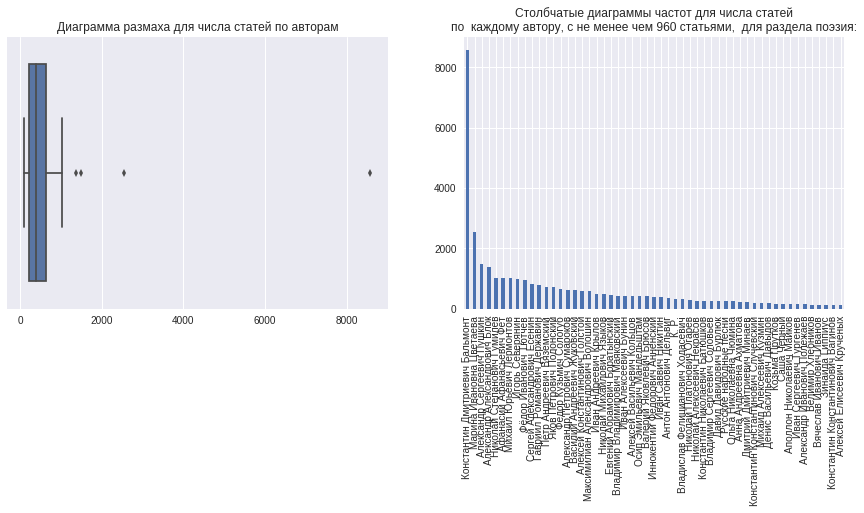

In [235]:
plt.subplots(1,2,figsize=(15,5));
plt.subplot(1,2,1)
sns.boxplot(poetry_counts[poetry_counts.values>100].values);
plt.title('Диаграмма размаха для числа статей по авторам');

plt.subplot(1,2,2)
poetry_counts[poetry_counts.values>100].plot.bar();
plt.title('Столбчатые диаграммы частот для числа статей\nпо  каждому автору, с не менее чем'
          ' {} статьями,  для раздела поэзия:'.format(threshold));

In [236]:
# %%time
# from tqdm import tqdm_notebook
# lengths = []
# for i, article_id in enumerate(tqdm_notebook(mask[mask].index)):
#     content = get_content(article_id).strip()
#     lengths.append(len(content))
# lengths = pd.Series(lengths)

Общее число символов в произведениях всех авторов в данном разделе: 30236938


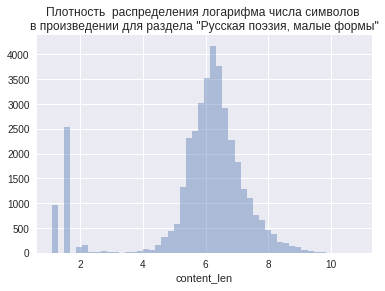

In [237]:
lengths = df[mask]['content_len']
sns.distplot(np.log(lengths+1), kde=False);
plt.title('Плотность  распределения логарифма числа символов \nв произведении для раздела "Русская поэзия, малые формы"');
print('Общее число символов в произведениях всех авторов в данном разделе:', df[mask]['content_len'].sum())

## *"Русская проза, малые формы"*

In [238]:
_, mask = analyze_category_mask('Русская проза, малые формы', 20, (10,90));

Общее число статей в категории: 4304
Число уникальных авторов в разделе Русская проза, малые формы: 109
Число уникальных авторов в разделе Русская проза, малые формы с более чем 20 статьями: 33
Общее число их статей в разделе Русская проза, малые формы: 3789
Можно утверждать, что число статей для 0.800  авторов из выборки  лежит в интервале: (23.2,251.2000000000001)


Общее число символов в произведениях всех авторов в данном разделе: 71258166


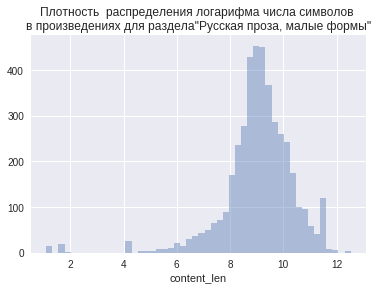

In [239]:
lengths = df[mask]['content_len']
sns.distplot(np.log(lengths+1), kde=False);
plt.title('Плотность  распределения логарифма числа символов \nв произведениях для раздела'
          '"Русская проза, малые формы"');
print('Общее число символов в произведениях всех авторов в данном разделе:', df[mask]['content_len'].sum())

In [250]:
#print(get_content(6))